# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [2]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np
import matplotlib.dates as dates

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))
    #print(df.head())

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    #return mplleaflet.display()

#leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [3]:
#Import of data using variables for file path and name.
FilePath = 'data/C2A2_data/BinnedCsvs_d400/'
FileName = 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv'

source = pd.read_csv(FilePath + FileName)

In [4]:
#Adjusting date formats, each update reflected in a new column. Also resetting temperature to degrees, rather than tenths.
#Selecting out Month and Day as a column since that's how I will need to plot them later.
source['Temp']=source['Data_Value']/10
source['Date2'] = pd.to_datetime(source['Date'])
source['Date3'] = pd.to_datetime(source["Date"]).dt.strftime('%m-%d')

#Carving out 2015 data, putting 2005-2014 into a new df
source2015 = source[source['Date2'].dt.year==2015]
source2 = source[source['Date2'].dt.year!=2015]
#Get rid of leap days
source3 = source2[source2['Date3']!='02-29']

print(source3.head())

            ID        Date Element  Data_Value  Temp      Date2  Date3
0  USW00094889  2014-11-12    TMAX          22   2.2 2014-11-12  11-12
1  USC00208972  2009-04-29    TMIN          56   5.6 2009-04-29  04-29
2  USC00200032  2008-05-26    TMAX         278  27.8 2008-05-26  05-26
3  USC00205563  2005-11-11    TMAX         139  13.9 2005-11-11  11-11
4  USC00200230  2014-02-27    TMAX        -106 -10.6 2014-02-27  02-27


In [5]:
#Separate dfs for record highs and lows
RecordHigh = source3[(source3.Element == 'TMAX')]
RecordHigh = RecordHigh[['Date3','Temp']]
RecordHigh =RecordHigh.groupby('Date3').max().reset_index()

RecordLow = source3[(source3.Element == 'TMIN')]
RecordLow = RecordLow[['Date3','Temp']]
RecordLow = RecordLow.groupby('Date3').min().reset_index()

#print(type(RecordHigh['Date3']))

In [6]:
#Getting the points where the 2015 data exceeds what's in the 2005-2014 data
#First step: for both TMAX and TMIN, group them by date and rename temp column for later merging
high2015=source2015[(source2015.Element=='TMAX')].rename(columns={'Temp':'TempHigh2015'}).groupby('Date3').max().reset_index()
low2015= source2015[(source2015.Element=='TMIN')].rename(columns={'Temp':'TempLow2015'}).groupby('Date3').min().reset_index()

#Now, merge them on the date ('how' should not really matter since there should be a perfect match on Date3 column)
HighMerge = pd.merge(RecordHigh, high2015, on='Date3', how='left')
LowMerge = pd.merge(RecordLow, low2015, on='Date3', how='left')

#Now, select the points where the 2015 value was outside the range of those in 2005-2014
OutlierHigh = HighMerge[(HighMerge['TempHigh2015'] > HighMerge['Temp'])]
OutlierLow = LowMerge[(LowMerge['TempLow2015'] < LowMerge['Temp'])]





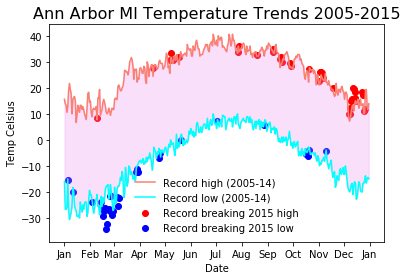

In [7]:
# Plot creation
date_xaxis = np.arange('2015-01-01','2016-01-01', dtype='datetime64')
plt.clf()
plt.figure()
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))

plt.plot(date_xaxis,RecordHigh['Temp'],c='salmon')
plt.plot(date_xaxis,RecordLow['Temp'],c='cyan')
plt.scatter(OutlierHigh.Date2.values, OutlierHigh['TempHigh2015'],c='red')
plt.scatter(OutlierLow.Date2.values, OutlierLow['TempLow2015'], c='blue')
plt.fill_between(date_xaxis, RecordHigh['Temp'], RecordLow['Temp'], color='violet', alpha=.25)

plt.legend(['Record high (2005-14)','Record low (2005-14)','Record breaking 2015 high','Record breaking 2015 low'],loc=0,frameon=False)

plt.xlabel('Date')
plt.ylabel('Temp Celsius')
plt.title('Ann Arbor MI Temperature Trends 2005-2015', fontsize=16)
#plt.xticks(labels=dates.MonthLocator())

plt.show()